In [15]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display
import scipy.signal
import os
import requests
import tarfile  # <-- use this for .tar.bz2
from scipy.io import wavfile

# Download LJ Speech Dataset
!wget https://data.keithito.com/data/speech/LJSpeech-1.1.tar.bz2

# Extract only the first 30 WAV files
download_dir = "LJSpeech-1.1"
os.makedirs(download_dir, exist_ok=True)

with tarfile.open("LJSpeech-1.1.tar.bz2", "r:bz2") as file:
    count = 0
    for member in file.getmembers():
        if member.name.endswith(".wav") and count < 30:
            file.extract(member, path=".")
            count += 1
        if count >= 30:
            break

print(f"Downloaded 30 audio samples to: {download_dir}")



--2025-04-14 09:39:20--  https://data.keithito.com/data/speech/LJSpeech-1.1.tar.bz2
Resolving data.keithito.com (data.keithito.com)... 79.127.213.215, 2400:52e0:1500::867:1
Connecting to data.keithito.com (data.keithito.com)|79.127.213.215|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2748572632 (2.6G) [text/plain]
Saving to: ‘LJSpeech-1.1.tar.bz2.1’

LJSpeech-1.1.tar.bz 100%[===================>]   2.56G   213MB/s    in 20s     

2025-04-14 09:39:41 (129 MB/s) - ‘LJSpeech-1.1.tar.bz2.1’ saved [2748572632/2748572632]

Downloaded 30 audio samples to: LJSpeech-1.1


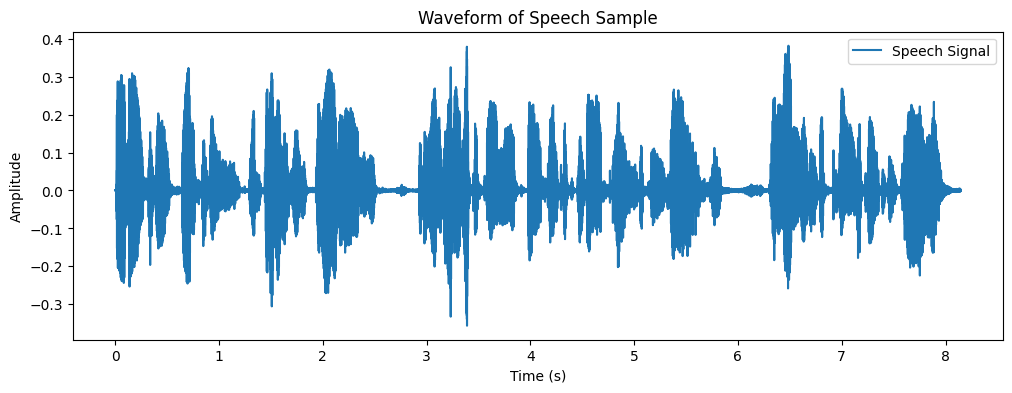

In [ ]:
# Select a sample file
sample_file = "/content/LJSpeech-1.1/wavs/LJ004-0026.wav"
signal, sr = librosa.load(sample_file, sr=16000)  # Ensure sample rate is 16 kHz 

# Plot waveform
time = np.linspace(0, len(signal) / sr, num=len(signal))
plt.figure(figsize=(12, 4))
plt.plot(time, signal, label='Speech Signal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Waveform of Speech Sample')
plt.legend()
plt.show()

In [21]:
import numpy as np
import matplotlib.pyplot as plt

# === Define feature extraction functions ===
def short_time_energy(frame):
    return np.sum(frame ** 2)

def short_time_magnitude(frame):
    return np.sum(np.abs(frame))

def zero_crossing_rate(frame):
    return np.sum(np.abs(np.diff(np.sign(frame)))) / (2 * len(frame))

def autocorrelation(frame, k=1):
    # Auto-correlation at lag k (not just zero-lag)
    return np.sum(frame[:-k] * frame[k:])

def amdf(frame, k=1):
    return np.sum(np.abs(frame[:-k] - frame[k:]))

def amsdf(frame, k=1):
    diff = frame[:-k] - frame[k:]
    return np.sum(diff ** 2) / (np.sum(frame ** 2) + 1e-8)

In [22]:
# === Main feature extraction function ===
def extract_features(signal, sample_rate, frame_duration=0.02, hop_duration=0.01):
    frame_size = int(frame_duration * sample_rate)
    hop_size = int(hop_duration * sample_rate)
    hamming_window = np.hamming(frame_size)

    ste, stm, zcr, acf, amdf_vals, amsdf_vals = [], [], [], [], [], []

    for i in range(0, len(signal) - frame_size, hop_size):
        frame = signal[i:i+frame_size] * hamming_window
        ste.append(short_time_energy(frame))
        stm.append(short_time_magnitude(frame))
        zcr.append(zero_crossing_rate(frame))
        acf.append(autocorrelation(frame, k=1))
        amdf_vals.append(amdf(frame, k=1))
        amsdf_vals.append(amsdf(frame, k=1))

    time_axis = np.arange(len(ste)) * hop_duration
    return {
        "STE": np.array(ste),
        "STM": np.array(stm),
        "ZCR": np.array(zcr),
        "Autocorrelation": np.array(acf),
        "AMDF": np.array(amdf_vals),
        "AMSDF": np.array(amsdf_vals),
        "time_axis": time_axis
    }

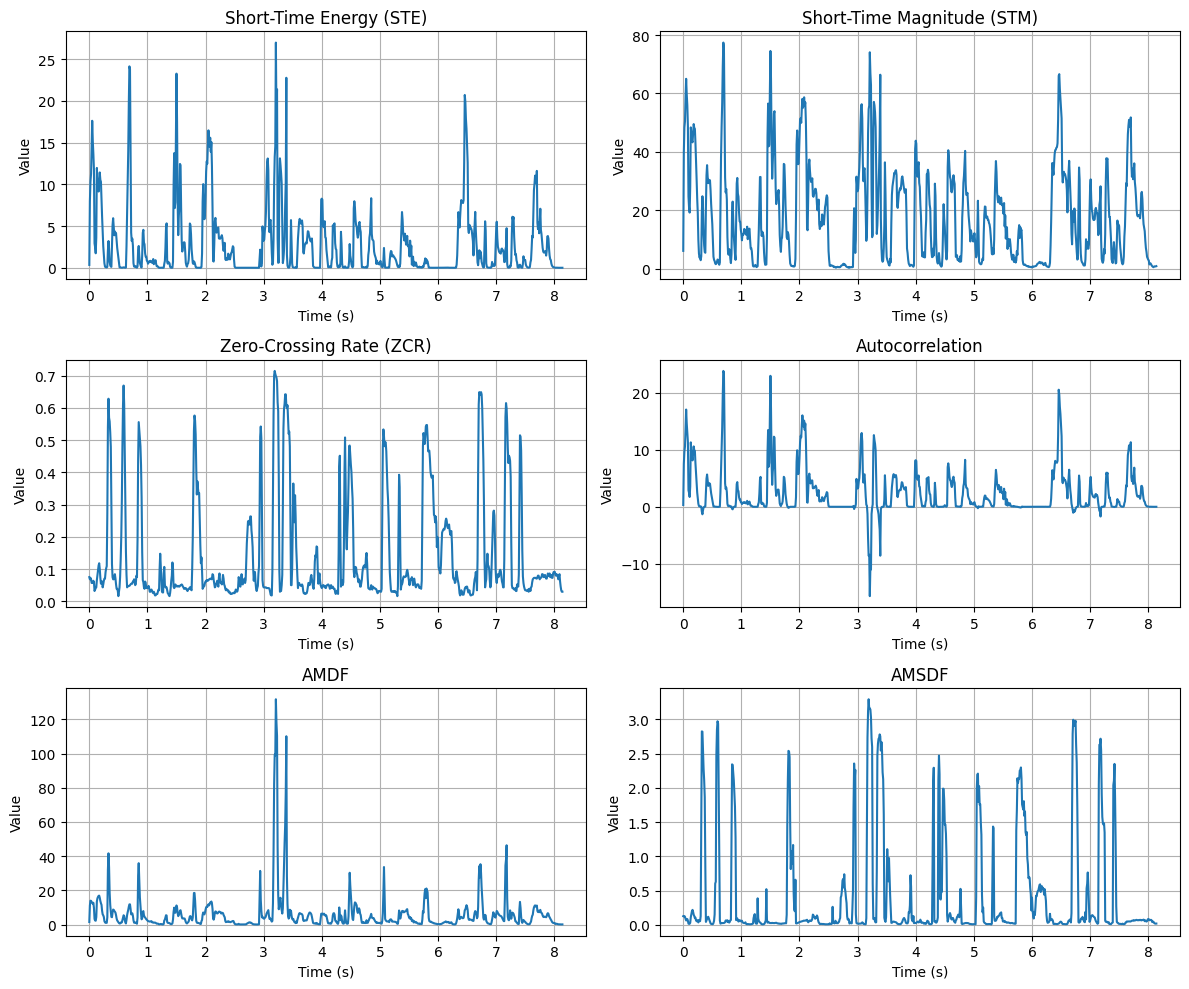

In [23]:
from scipy.io import wavfile
sample_rate, signal = wavfile.read('/content/LJSpeech-1.1/wavs/LJ004-0026.wav')  # Load your WAV file here
signal = signal / np.max(np.abs(signal))  # Normalize

# Extract features
features = extract_features(signal, sample_rate)

# === Plotting ===
titles = ["Short-Time Energy (STE)", "Short-Time Magnitude (STM)", "Zero-Crossing Rate (ZCR)",
          "Autocorrelation", "AMDF", "AMSDF"]
keys = ["STE", "STM", "ZCR", "Autocorrelation", "AMDF", "AMSDF"]

plt.figure(figsize=(12, 10))
for i, key in enumerate(keys):
    plt.subplot(3, 2, i+1)
    plt.plot(features["time_axis"], features[key])
    plt.title(titles[i])
    plt.xlabel("Time (s)")
    plt.ylabel("Value")
    plt.grid(True)

plt.tight_layout()
plt.show()
